<a href="https://colab.research.google.com/github/nikibhatt/DS-Unit-2-Applied-Modeling/blob/master/module2/NB_project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

In [0]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

listings = pd.read_csv('listings.csv')

listings.shape

(7435, 16)

In [0]:
listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,4952,Butterfly Inn - Graceful Living !,7054,Mei Lin,NaN,Palo Alto,37.43972,-122.15672,Private room,90,2,75,2019-01-12,0.61,5,52
1,11464,Deluxe Private Studio-custom int.,42458,Emey,NaN,Santa Clara,37.34342,-121.98829,Entire home/apt,85,14,5,2018-08-26,0.08,10,90
2,21373,Bonsai Garden Inn in Professorville,7054,Mei Lin,NaN,Palo Alto,37.44001,-122.15667,Private room,99,2,240,2019-09-15,2.12,5,276
3,23732,Heart of Silicon Valley bdrm & bath,2077,Igor,NaN,Mountain View,37.39203,-122.06675,Private room,299,1,3,2011-07-07,0.03,1,365
4,37154,Private room in a 2 bedroom home in Campbell,160433,Daniel,NaN,San Jose,37.30213,-121.95890,Private room,61,2,36,2019-09-13,2.41,1,26


In [3]:
import pandas_profiling

profile_report = listings.profile_report(
    check_correlation_pearson=False,
    correlations={
        'pearson': False,
        'spearman': False,
        'kendall': False,
        'phi_k': False,
        'cramers': False,
        'recoded': False,
    },
    plot={'histogram': {'bayesian_blocks_bins': False}},
)

profile_report

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(listings, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

In [8]:
train.shape, val.shape, test.shape

((4758, 16), (1190, 16), (1487, 16))

In [10]:
# The status_group column is the target
target = 'price'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id', 'neighbourhood_group'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)

['host_id', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'neighbourhood', 'room_type']


In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [0]:
from sklearn.tree import DecisionTreeClassifier
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    DecisionTreeClassifier(random_state=42)
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on train, val
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Val Accuracy', pipeline.score(X_val, y_val))

# Predict on test
y_pred = pipeline.predict(X_test)


Train Accuracy 0.9952861952861953
Val Accuracy 0.7537878787878788


In [0]:
#Reducing complexity of the tree - this time it comes at the cost of accuracy

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    DecisionTreeClassifier(min_samples_leaf=20, random_state=42)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))

Train Accuracy 0.8117340067340068


In [0]:
#Making the tree shorter - again it comes at the cost of accuracy

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    DecisionTreeClassifier(max_depth=16, random_state=42)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))

Train Accuracy 0.8426767676767677


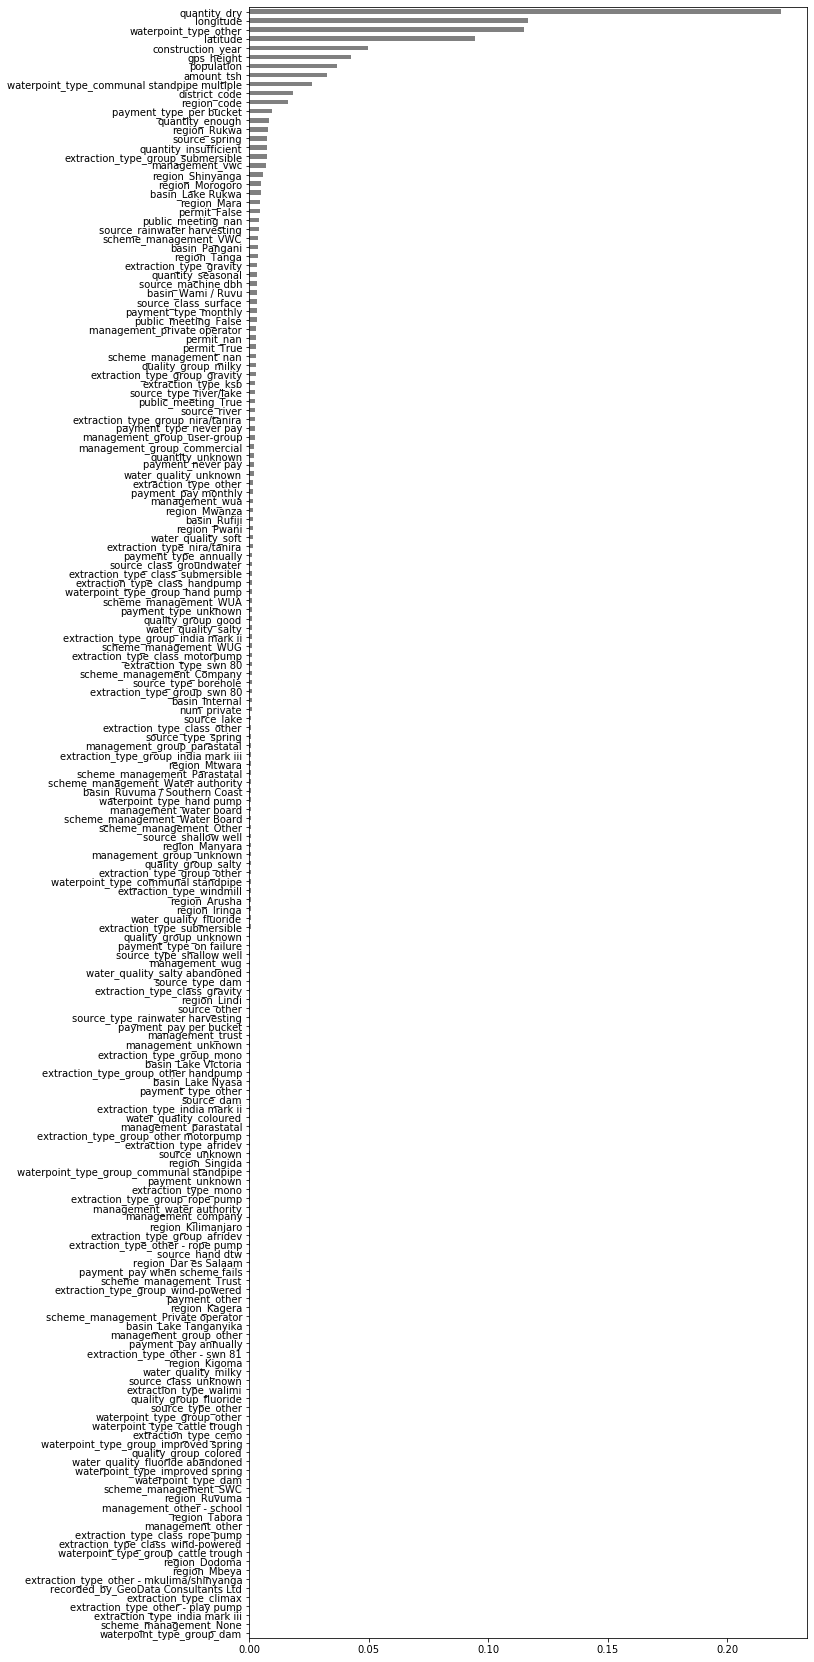

In [0]:
import matplotlib.pyplot as plt

model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_test).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey')

In [0]:
y_pred

array(['non functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

In [0]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('niki.csv', index=False)

In [0]:
from google.colab import files
files.download('niki.csv')